In [1]:
import numpy as np
import pandas as pd
import openturns as ot
from matplotlib import cm, colormaps
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

In [2]:
from matplotlib import rc
rc('font', **{'family': 'Libertine'})
rc('text', usetex=True)
rc('text', usetex=True)
plt.rcParams.update({'text.latex.preamble': r'\usepackage{amsfonts}'})
plt.rcParams.update({'text.latex.preamble': r'\usepackage{amsmath}'})
plt.rcParams.update({'text.latex.preamble': r'\usepackage{bm}'})
rc('font', size=16)# Set the default text font size
rc('axes', titlesize=20)# Set the axes title font size
rc('axes', labelsize=16)# Set the axes labels font size
rc('xtick', labelsize=16)# Set the font size for x tick labels
rc('ytick', labelsize=16)# Set the font size for y tick labels
rc('legend', fontsize=16)# Set the legend font size

In [3]:
class DrawFunctions:
    """
    """
    def __init__(self):
        self.dim = 2
        self.grid_size = 500
        lowerbound = [-7.5] * self.dim
        upperbound = [7.5] * self.dim
        self.set_bounds(lowerbound, upperbound)

    def set_bounds(self, lowerbound, upperbound):
        mesher = ot.IntervalMesher([self.grid_size-1] * self.dim)
        interval = ot.Interval(lowerbound, upperbound)
        mesh = mesher.build(interval)
        self.nodes = mesh.getVertices()
        self.X0, self.X1 = np.array(self.nodes).T.reshape(self.dim, self.grid_size, self.grid_size)
        return None

    def draw_2D_controur(self, title, function=None, distribution=None, colorbar=cm.coolwarm, cbar_label=None, nb_isocurves=8, contour_values=True):
        fig = plt.figure(figsize=(7, 6))
        if distribution is not None:
            Zpdf = np.array(distribution.computePDF(self.nodes)).reshape(self.grid_size, self.grid_size)
            contours = plt.contour(self.X0, self.X1, Zpdf, nb_isocurves, colors='black', alpha=0.3)
            if contour_values:
                plt.clabel(contours, inline=True, fontsize=8)
        if function is not None:
            self.Z = np.array(function(self.nodes)).reshape(self.grid_size, self.grid_size)
            plt.contourf(self.X0, self.X1, self.Z, 10, cmap=colorbar)
            plt.colorbar(label=cbar_label)
        plt.title(title, fontsize=20)
        plt.xlabel("$x_1$", fontsize=20)
        plt.ylabel("$x_2$", fontsize=20)       
        return fig

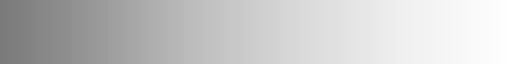

In [4]:
greys = colormaps['Greys_r']
faded_greys = ListedColormap(greys(np.linspace(0.4, 1, 128)))
faded_greys

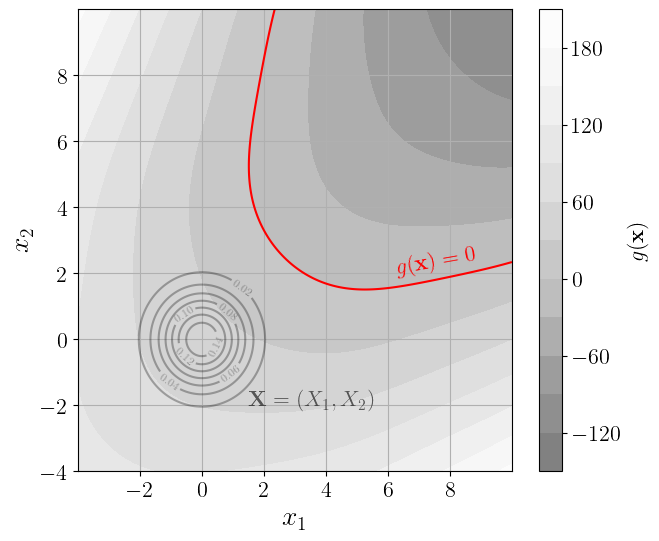

In [5]:
g = ot.SymbolicFunction(["x1", "x2"], ["(x1 - x2) ^ 2 - 8 * (x1 + x2 - 5) + sin(x1) + sin(x2)"])
X = ot.ComposedDistribution([ot.Normal(0., 1.)] * 2)
Y = ot.CompositeRandomVector(g, ot.RandomVector(X))
threshold = 0.
failure_event = ot.ThresholdEvent(Y, ot.LessOrEqual(), threshold)
d = DrawFunctions()
d.set_bounds([-4] * 2, [10] * 2)
d.draw_2D_controur(title="", function=g, distribution=X, colorbar=faded_greys, cbar_label="$g(\\mathbf{x})$")
contour = plt.contour(d.X0, d.X1, d.Z, levels=[threshold], colors='red')
#plt.clabel(contour, inline=True, fontsize=12, colors='k')
plt.text(1.5, -2., "$\\mathbf{X} = (X_1, X_2)$", fontsize=16, alpha=0.6)
plt.text(6.2, 2., "$g(\\mathbf{x}) = 0$", fontsize=16, color='red', rotation=10)
plt.grid()
plt.xticks(range(-2, 10, 2))
plt.yticks(range(-4, 10, 2))
plt.savefig("figures/parabolic_problem.png", dpi=300, bbox_inches='tight');

## Crude Monte Carlo

In [6]:
N = int(1e5)
x_mc = np.array(X.getSample(N))
y_mc = np.array(g(x_mc))
mc_sample = np.concatenate([x_mc, y_mc], axis=1)
x_failed = mc_sample[y_mc.flatten() <= 0, :-1]

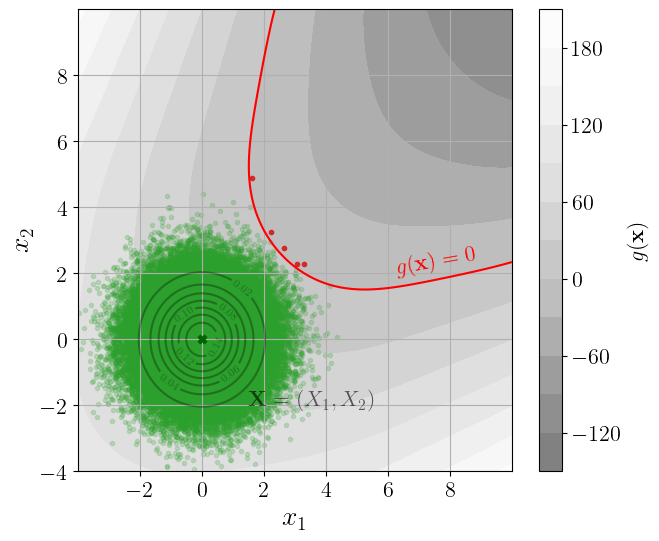

In [7]:
d = DrawFunctions()
d.set_bounds([-4] * 2, [10] * 2)
d.draw_2D_controur(title=None, function=g, distribution=X, colorbar=faded_greys, cbar_label="$g(\\mathbf{x})$")
contour = plt.contour(d.X0, d.X1, d.Z, levels=[threshold], colors='red')
#plt.clabel(contour, inline=True, fontsize=12, colors='k')
plt.scatter(x_mc[:, 0], x_mc[:, 1], color='C2', marker='.', alpha=0.2)
plt.scatter(x_failed[:, 0], x_failed[:, 1], color='C3', marker='.')
plt.scatter(0, 0, color='darkgreen', marker='X', zorder=3)

plt.xlim(-4, 10)
plt.ylim(-4, 10)
plt.xticks(range(-2, 10, 2))
plt.yticks(range(-4, 10, 2))
plt.text(1.5, -2, "$\\mathbf{X} = (X_1, X_2)$", fontsize=16, alpha=0.6)
plt.text(6.2, 2., "$g(\\mathbf{x}) = 0$", fontsize=16, color='red', rotation=10)
plt.grid()

plt.savefig("figures/reliability_MC_illustration.png", dpi=300, bbox_inches='tight');

## FORM / SORM

In [8]:
algo = ot.FORM(ot.Cobyla(), failure_event, X.getMean())
algo.run()
result = algo.getResult()
beta = result.getHasoferReliabilityIndex()
importance_factors = result.getImportanceFactors()
u_star = result.getStandardSpaceDesignPoint()

In [9]:
# FORM 
algo = ot.LinearTaylor(u_star, g)
algo.run()
linear_approx = algo.getMetaModel()
linear_Z = np.array(linear_approx(d.nodes)).reshape(d.grid_size, d.grid_size)
# SORM 
algo = ot.QuadraticTaylor(u_star, g)
algo.run()
quadratic_approx = algo.getMetaModel()
quadratic_Z = np.array(quadratic_approx(d.nodes)).reshape(d.grid_size, d.grid_size)

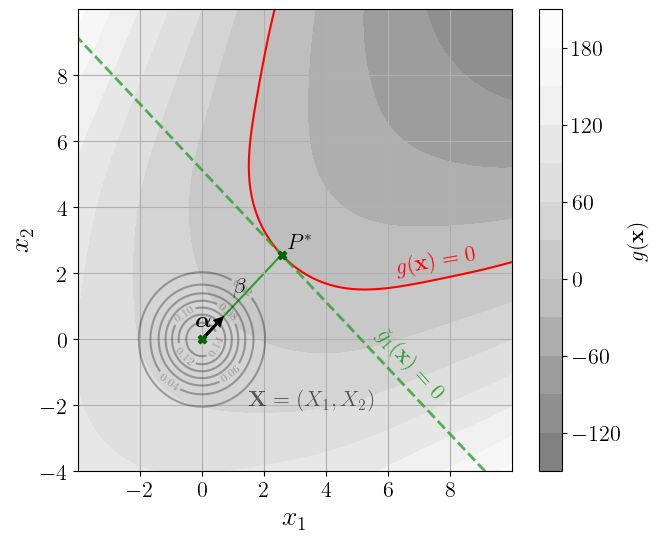

In [10]:
d = DrawFunctions()
d.set_bounds([-4] * 2, [10] * 2)
d.draw_2D_controur(title="", function=g, distribution=X, colorbar=faded_greys, cbar_label="$g(\\mathbf{x})$")
contour = plt.contour(d.X0, d.X1, d.Z, levels=[threshold], colors='red')
plt.scatter(0, 0, color='darkgreen', marker='X', zorder=3)
#plt.clabel(contour, inline=True, fontsize=12, colors='k')

plt.scatter(u_star[0], u_star[1], color='darkgreen', marker='X', zorder=3)
plt.contour(d.X0, d.X1, linear_Z, [0.], colors='C2', alpha=0.8, linestyles="dashed", linewidths=2)
plt.plot([0, u_star[0]], [0, u_star[1]], color="C2", zorder=1)
plt.arrow(0, 0, importance_factors[0], importance_factors[1], head_width=0.2, head_length=0.2, fc='k', ec='k', linewidth=2, zorder=1)

plt.text(u_star[0] + 0.2, u_star[1] + 0.2, "$P^*$")
plt.text(-0.2, 0.4, "$\\bm{\\alpha}$")
plt.text(1, 1.4, "$\\beta$")
plt.text(1.5, -2, "$\\mathbf{X} = (X_1, X_2)$", fontsize=16, alpha=0.6)
plt.text(6.2, 2., "$g(\\mathbf{x}) = 0$", fontsize=16, color='red', rotation=10)
plt.text(5.5, -1.8, "$\\check{g}_1(\\mathbf{x}) = 0$", rotation=-48, color="C2")
plt.grid()
plt.xticks(range(-2, 10, 2))
plt.yticks(range(-4, 10, 2))
plt.savefig("figures/reliability_FORM_illustration.png", dpi=300, bbox_inches='tight');

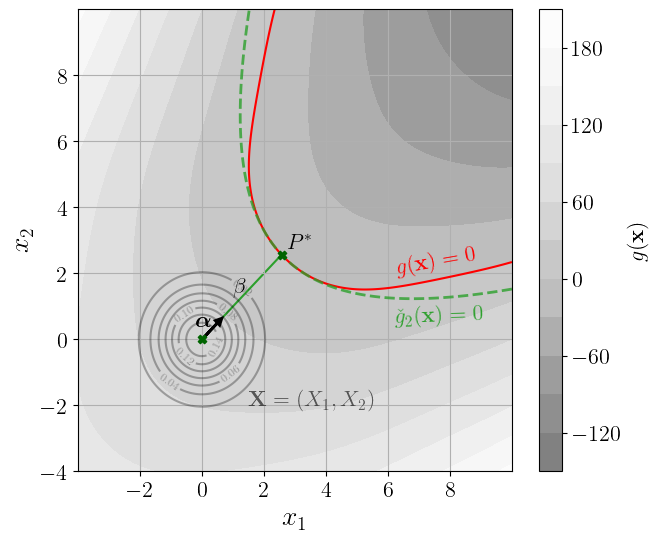

In [11]:
d = DrawFunctions()
d.set_bounds([-4] * 2, [10] * 2)
d.draw_2D_controur(title="", function=g, distribution=X, colorbar=faded_greys, cbar_label="$g(\\mathbf{x})$")
contour = plt.contour(d.X0, d.X1, d.Z, levels=[threshold], colors='red')
plt.scatter(0, 0, color='darkgreen', marker='X', zorder=3)
#plt.clabel(contour, inline=True, fontsize=12, colors='k')

plt.scatter(u_star[0], u_star[1], color='darkgreen', marker='X', zorder=3)
plt.contour(d.X0, d.X1, quadratic_Z, [0.], colors='C2', alpha=0.8, linestyles="dashed", linewidths=2)
plt.plot([0, u_star[0]], [0, u_star[1]], color="C2", zorder=1)
plt.arrow(0, 0, importance_factors[0], importance_factors[1], head_width=0.2, head_length=0.2, fc='k', ec='k', linewidth=2, zorder=1)

plt.text(u_star[0] + 0.2, u_star[1] + 0.2, "$P^*$")
plt.text(-0.2, 0.4, "$\\bm{\\alpha}$")
plt.text(1, 1.4, "$\\beta$")
plt.text(1.5, -2, "$\\mathbf{X} = (X_1, X_2)$", fontsize=16, alpha=0.6)
plt.text(6.2, 2., "$g(\\mathbf{x}) = 0$", fontsize=16, color='red', rotation=10)
plt.text(6.2, 0.5, "$\\check{g}_2(\\mathbf{x}) = 0$", rotation=2, color="C2")
plt.grid()
plt.xticks(range(-2, 10, 2))
plt.yticks(range(-4, 10, 2))
plt.savefig("figures/reliability_SORM_illustration.png", dpi=300, bbox_inches='tight');

## Importance sampling

In [12]:
X_is  = ot.Normal(2)
X_is.setMean(u_star)

x_mc = np.array(X_is.getSample(N))
y_mc = np.array(g(x_mc))
mc_sample = np.concatenate([x_mc, y_mc], axis=1)
x_failed = mc_sample[y_mc.flatten() <= 0, :-1]

<Figure size 300x300 with 0 Axes>

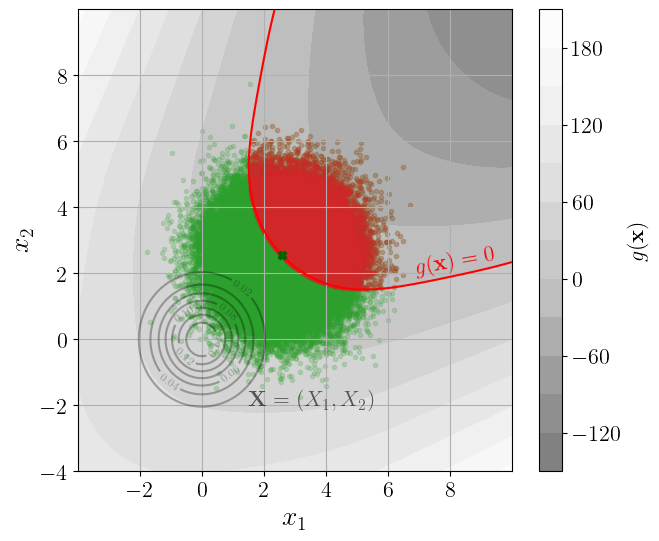

In [13]:
plt.figure(figsize=(3,3))
d = DrawFunctions()
d.set_bounds([-4] * 2, [10] * 2)
d.draw_2D_controur(title=None, function=g, distribution=X, colorbar=faded_greys, cbar_label="$g(\\mathbf{x})$")
contour = plt.contour(d.X0, d.X1, d.Z, levels=[threshold], colors='red')
#plt.clabel(contour, inline=True, fontsize=12, colors='k')
plt.scatter(x_mc[:, 0], x_mc[:, 1], color='C2', marker='.', alpha=0.2)
plt.scatter(x_failed[:, 0], x_failed[:, 1], color='C3', marker='.', alpha=0.2)
plt.scatter(u_star[0], u_star[1], color='darkgreen', marker='X', zorder=3)

plt.xlim(-4, 10)
plt.ylim(-4, 10)
plt.xticks(range(-2, 10, 2))
plt.yticks(range(-4, 10, 2))
plt.text(1.5, -2, "$\\mathbf{X} = (X_1, X_2)$", fontsize=16, alpha=0.6)
plt.text(6.8, 2., "$g(\\mathbf{x}) = 0$", fontsize=16, color='red', rotation=10)
plt.grid()
plt.savefig("figures/reliability_IS_illustration.png", dpi=300, bbox_inches='tight');

## subset simulation

In [14]:
N

100000

In [15]:
# Reliability problem
g = ot.MemoizeFunction(g)
Y = ot.CompositeRandomVector(g, ot.RandomVector(X))
failure_event = ot.ThresholdEvent(Y, ot.LessOrEqual(), threshold)
# Subset simulation setup 
algo = ot.SubsetSampling(failure_event)
algo.setMaximumOuterSampling(int(1e4))
algo.setKeepEventSample(True)
algo.run()
result = algo.getResult()
levels = algo.getThresholdPerStep()

In [16]:
input_subsets_samples = np.array(g.getInputHistory())
output_subsets_samples = np.array(g.getOutputHistory())
N = algo.getMaximumOuterSampling() * algo.getBlockSize()
nb_subset = algo.getStepsNumber()
N_total = result.getOuterSampling()

In [17]:
subset_indexes = np.repeat((np.arange(nb_subset)), N).reshape(-1, 1)
df_ss = pd.DataFrame(np.concatenate((subset_indexes, input_subsets_samples, output_subsets_samples), axis=1))
df_ss.columns = ["Subset"] + list(X.getDescription()) + ["Y"]

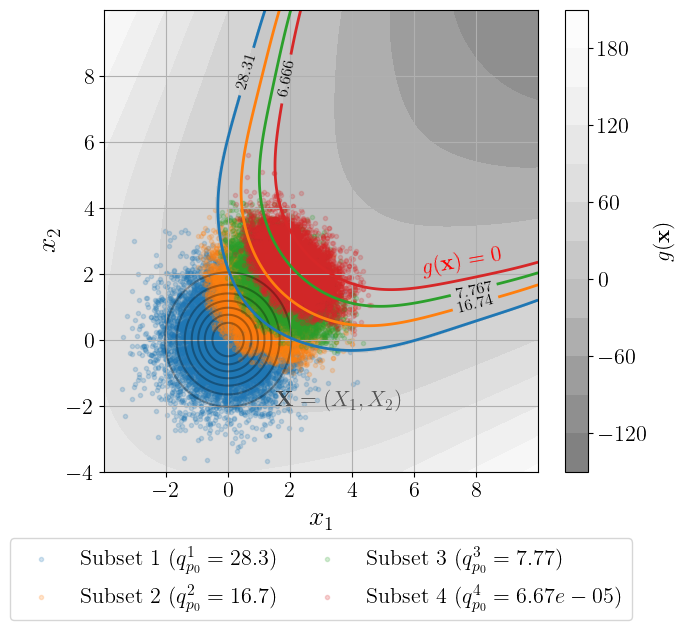

In [18]:
d = DrawFunctions()
d.set_bounds([-4] * 2, [10] * 2)
d.draw_2D_controur(title=None, function=g, distribution=X, colorbar=faded_greys, contour_values=False, cbar_label="$g(\\mathbf{x})$")
for i in range(nb_subset-1):
    ssample = df_ss[(df_ss["Subset"]==i) ]
    x0 = ssample["X0"].values
    x1 = ssample["X1"].values
    sslabel = "Subset {} ($q_{{p_0}}^{} = {:.3}$)".format(i+1, i+1, levels[i])
    sslabel = "Subset {} ($q_{{p_0}}^{} = {:.3}$)".format(i+1, i+1, levels[i])
    plt.scatter(x0, x1, color='C{}'.format(i), marker='.', alpha=0.2, label=sslabel)
    contour = plt.contour(d.X0, d.X1, d.Z, levels=[levels[i]], colors='C{}'.format(i), linewidths=2, linestyles=['solid'])
    plt.clabel(contour, inline=True, fontsize=12, colors='k')
plt.xlim(-4, 10)
plt.ylim(-4, 10)
plt.xticks(range(-2, 10, 2))
plt.yticks(range(-4, 10, 2))
plt.text(1.5, -2, "$\\mathbf{X} = (X_1, X_2)$", fontsize=16, alpha=0.6)
plt.text(6.2, 2., "$g(\\mathbf{x}) = 0$", fontsize=16, color='red', rotation=10)
plt.grid()

plt.legend(bbox_to_anchor=(0.5, -0.12), loc='upper center', ncol=2, columnspacing=1.2)
#plt.savefig("figures/subset_4branch.pdf", bbox_inches='tight')
plt.savefig("figures/reliability_SS_illustration.png", bbox_inches='tight', dpi=300);

## Multi-FORM design points

In [19]:
g1 = ot.SymbolicFunction(["x1", "x2"], ["4.0 - (x2-1) - 0.4 * x1^2"])
X = ot.ComposedDistribution([ot.Normal(0., 1.)] * 2)
Y = ot.CompositeRandomVector(g1, ot.RandomVector(X))
threshold = 0.
failure_event = ot.ThresholdEvent(Y, ot.LessOrEqual(), threshold)

In [20]:
# MULTI-FORM
multi_algo = ot.MultiFORM(ot.Cobyla(), failure_event, X.getMean())
multi_algo.run()
multi_form_results = multi_algo.getResult()
FORM1 = multi_form_results.getFORMResultCollection()[0]
FORM2 = multi_form_results.getFORMResultCollection()[1]
u_star1 = FORM1.getPhysicalSpaceDesignPoint()
u_star2 = FORM2.getPhysicalSpaceDesignPoint()
beta = FORM1.getHasoferReliabilityIndex()

In [21]:
d = DrawFunctions()
d.set_bounds([-6] * 2, [6] * 2)
# FORM1 
algo1 = ot.LinearTaylor(u_star1, g1)
algo1.run()
linear_approx1 = algo1.getMetaModel()
linear_Z_1 = np.array(linear_approx1(d.nodes)).reshape(d.grid_size, d.grid_size)
# FORM2 
algo2 = ot.LinearTaylor(u_star2, g1)
algo2.run()
linear_approx2 = algo2.getMetaModel()
linear_Z_2 = np.array(linear_approx2(d.nodes)).reshape(d.grid_size, d.grid_size)

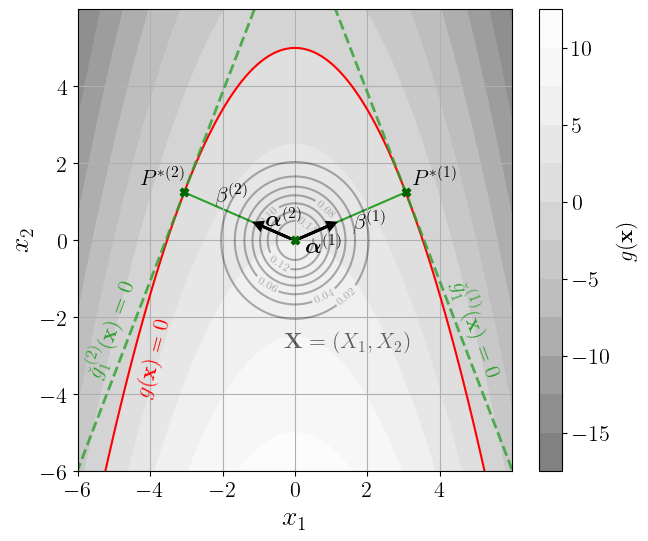

In [22]:
d.draw_2D_controur(title="", function=g1, distribution=X, colorbar=faded_greys, cbar_label="$g(\\mathbf{x})$")
contour = plt.contour(d.X0, d.X1, d.Z, levels=[threshold], colors='red')
#plt.clabel(contour, inline=True, fontsize=12, colors='k')

plt.scatter([0, u_star1[0], u_star2[0]], [0, u_star1[1], u_star2[1]], color='darkgreen', marker='X', zorder=3)
plt.contour(d.X0, d.X1, linear_Z_1, [0.], colors='C2', alpha=0.8, linestyles="dashed", linewidths=2)
plt.contour(d.X0, d.X1, linear_Z_2, [0.], colors='C2', alpha=0.8, linestyles="dashed", linewidths=2)

plt.plot([0, u_star1[0]], [0, u_star1[1]], color="C2", zorder=1)
plt.plot([0, u_star2[0]], [0, u_star2[1]], color="C2", zorder=1)
plt.arrow(0, 0, u_star1[0] / beta, u_star1[1] / beta, head_width=0.2, head_length=0.2, fc='k', ec='k', linewidth=2, zorder=1)
plt.arrow(0, 0, -u_star1[0] / beta, u_star1[1] / beta, head_width=0.2, head_length=0.2, fc='k', ec='k', linewidth=2, zorder=1)

plt.text(-0.3, -2.8, "$\\mathbf{X} = (X_1, X_2)$", fontsize=16, alpha=0.6)
plt.text(-4.5, -4., "$g(\\mathbf{x}) = 0$", fontsize=16, color='red', rotation=75)

plt.text(4.2, -3.5, "$\\check{g}_1^{(1)}(\\mathbf{x}) = 0$", rotation=-70, color="C2")
plt.text(-6, -3.5, "$\\check{g}_1^{(2)}(\\mathbf{x}) = 0$", rotation=70, color="C2")

plt.text(u_star1[0] + 0.2, u_star1[1] + 0.2, "$P^{*(1)}$")
plt.text(u_star2[0] - 1.2, u_star2[1] + 0.2, "$P^{*(2)}$")
plt.text(0.3, -0.3, "$\\bm{\\alpha}^{(1)}$")
plt.text(-0.8, 0.4, "$\\bm{\\alpha}^{(2)}$")

plt.text(1.6, 0.3, "$\\beta^{(1)}$")
plt.text(-2.2, 1, "$\\beta^{(2)}$")

plt.grid()
plt.xticks(range(-6, 6, 2))
plt.yticks(range(-6, 6, 2))
plt.savefig("figures/reliability_multiform.png", dpi=300, bbox_inches='tight');